In [185]:
%load_ext autoreload
%autoreload
from kofscraper import keywords_utils, config, load_utils
import polars as pl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TF-IDF

## Load data

In [3]:
patents = load_utils.load_multiple_files(config.PATENTS_DIR + "CH*.xlsx", "excel");

Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string
Could not determine dtype for column 3, falling back to string


In [4]:
patents = patents.with_columns(
    pl.col("Title").str.replace_all(r"[^\p{Ascii}]", ""),
    pl.col("Abstract").str.replace_all(r"[^\p{Ascii}]", "")
)

patent_company_lookup = load_utils.load_multiple_files(pattern = config.PATENTS_DIR + "Appl*.csv", filetype="csv")[:, 1:3].rename({"Applicant(s) BvD ID Number(s)": "ID"})
patent_company_lookup = patent_company_lookup.with_columns(pl.col("ID").str.split("; ")).explode("ID")

patents = patents.join(patent_company_lookup, on = "Publication number", how = "inner")


In [150]:
patents = patents.filter(pl.col("ID").str.starts_with("CHCHE")).unique()

## TF-IDF on patents

In [163]:
keywords_utils.get_tf_idf_language(patents.lazy(), "Abstract", chunk_size=60000, output_name='tf_idfs_patents')

Percent completed: 5.54%, Time remaining: 0:04:26
Percent completed: 11.08%, Time remaining: 0:04:12
Percent completed: 16.62%, Time remaining: 0:03:56
Percent completed: 22.16%, Time remaining: 0:03:40
Percent completed: 27.70%, Time remaining: 0:03:24
Percent completed: 33.25%, Time remaining: 0:03:09
Percent completed: 38.79%, Time remaining: 0:02:55
Percent completed: 44.33%, Time remaining: 0:02:39
Percent completed: 49.87%, Time remaining: 0:02:24
Percent completed: 55.41%, Time remaining: 0:02:08
Percent completed: 60.95%, Time remaining: 0:01:52
Percent completed: 66.49%, Time remaining: 0:01:36
Percent completed: 72.03%, Time remaining: 0:01:20
Percent completed: 77.57%, Time remaining: 0:01:04
Percent completed: 83.11%, Time remaining: 0:00:48
Percent completed: 88.66%, Time remaining: 0:00:32
Percent completed: 94.20%, Time remaining: 0:00:16
Percent completed: 99.74%, Time remaining: 0:00:00
Percent completed: 105.28%, Time remaining: -1 day, 23:59:46
Wrote results to 'data

In [198]:
tf_idf = pl.read_parquet(config.DATA_DIR + "processed/tf_idfs_patents.parquet")

In [199]:
tf_idf = tf_idf.filter(~pl.all_horizontal(pl.col("en", "it", "de", "fr") == False)).filter(~pl.col("word").str.contains(r"[0-9]"))\
    .sort("tf_idf", descending=True)

In [200]:
en_patents = tf_idf.filter(pl.col("en") == True).group_by("word").agg(pl.col("tf_idf").mean()).select("word", "tf_idf").sort('tf_idf', descending=True)

## TF-IDF on websites

In [186]:
lf = load_utils.load_parquets(config.CHUNK_DIR + "run_id=2025-11-21/parsed/").slice(0, 200_000).select("text")

File ARGUS_chunk_p183.parquet is corrupted


In [187]:
keywords_utils.get_tf_idf_language(lf.lazy(), "text", chunk_size=30000, output_name='tf_idfs_websites')


Percent completed: 15.00%, Time remaining: 0:07:49
Percent completed: 30.00%, Time remaining: 0:06:27
Percent completed: 45.00%, Time remaining: 0:06:00
Percent completed: 60.00%, Time remaining: 0:04:25
Percent completed: 75.00%, Time remaining: 0:02:58
Percent completed: 90.00%, Time remaining: 0:01:11
Percent completed: 105.00%, Time remaining: -1 day, 23:59:25
Wrote results to 'data/processed/tf_idfs_websites.parquet'
Cleaning up files...
Done.


In [201]:
tf_idf_websites = pl.read_parquet(config.DATA_DIR + "processed/tf_idfs_websites.parquet")

In [202]:
tf_idf_websites = tf_idf_websites.filter(~pl.all_horizontal(pl.col("en", "it", "de", "fr") == False)).filter(~pl.col("word").str.contains(r"[0-9]"))\
    .sort("tf_idf", descending=True)

In [203]:
en_websites = tf_idf_websites.filter(pl.col("en") == True).group_by('word').agg(pl.col("tf_idf").mean())

In [224]:
comparison = en_patents.join(en_websites, on = "word", how = "inner", suffix = "_website")

In [250]:
comparison = comparison.with_columns(
    difference = pl.col("tf_idf") - pl.col("tf_idf_website")
)

Text(0.5, 0, 'tf-idf patent - tf-idf website')

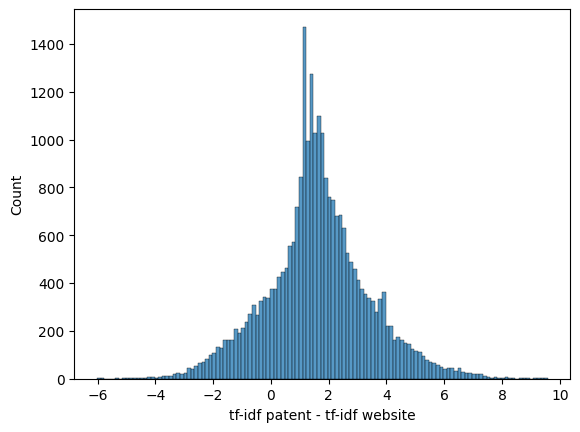

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(comparison["difference"])# - comparison["difference"].mean())
plt.xlabel("tf-idf patent - tf-idf website")

<Axes: xlabel='tf_idf', ylabel='difference'>

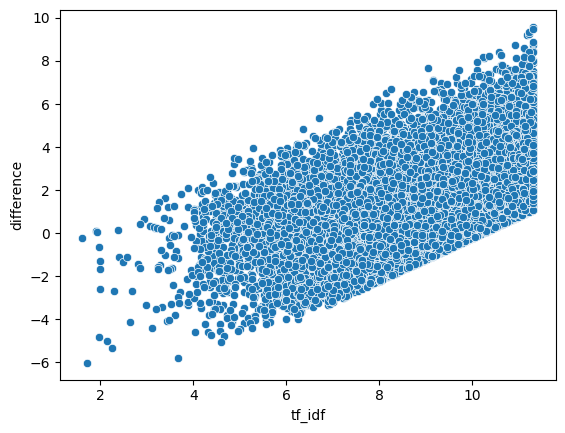

In [ ]:
attempt = comaprison.unpivot(in)
sns.scatterplot(x = comparison["tf_idf"], y = comparison["difference"])